# КЛАССИФИКАЦИЯ С ПОМОЩЬЮ ПЕРСЕПТРОНА


Цель работы: изучение модели нейрона персептрона и архитектуры персептронной однослойной нейронной сети; создание
и исследование моделей персептронных нейронных сетей

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
np.random.seed(13)
t = np.linspace(2.01, 10, 300) 
z_clean = np.cos(2 * t) * np.abs(t - 2)
noise = 0.15 * np.max(np.abs(z_clean)) * np.random.randn(len(t))  # 15% шума
z = z_clean + noise

# Подготовка данных для прогнозирования (метод скользящего окна)
def create_sequences(data, lookback=5):
    """Создание последовательностей для обучения LSTM"""
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

# Нормализация данных
scaler = MinMaxScaler()
z_scaled = scaler.fit_transform(z.reshape(-1, 1)).flatten()

# Создание последовательностей
lookback = 5
X, y = create_sequences(z_scaled, lookback)

# Разделение на обучающую и тестовую выборки (3:1)
train_size = int(0.75 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Преобразование в тензоры PyTorch
X_train = torch.FloatTensor(X_train).unsqueeze(2)  # [batch, seq_len, features]
y_train = torch.FloatTensor(y_train).unsqueeze(1)
X_test = torch.FloatTensor(X_test).unsqueeze(2)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

# LSTM сеть для прогнозирования
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

model = TimeSeriesLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение
print("Обучение LSTM для прогнозирования ВР (вариант 13)...")
loss_history = []
for epoch in range(150):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    
    if (epoch + 1) % 30 == 0:
        print(f"Эпоха {epoch+1}, MSE: {loss.item():.6f}")

# Прогнозирование
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).numpy()
    y_pred_test = model(X_test).numpy()
    
    # Обратное преобразование в исходный масштаб
    y_train_inv = scaler.inverse_transform(y_train.numpy())
    y_test_inv = scaler.inverse_transform(y_test.numpy())
    y_pred_train_inv = scaler.inverse_transform(y_pred_train)
    y_pred_test_inv = scaler.inverse_transform(y_pred_test)

# Расчёт метрик качества
mse_train = np.mean((y_train_inv - y_pred_train_inv)**2)
mse_test = np.mean((y_test_inv - y_pred_test_inv)**2)
mae_test = np.mean(np.abs(y_test_inv - y_pred_test_inv))

print(f"\nКачество прогнозирования (вариант 13):")
print(f"  MSE (обучение): {mse_train:.6f}")
print(f"  MSE (тест):     {mse_test:.6f}")
print(f"  MAE (тест):     {mae_test:.6f}")



Обучение LSTM для прогнозирования ВР (вариант 13)...
Эпоха 30, MSE: 0.023116
Эпоха 60, MSE: 0.019570
Эпоха 90, MSE: 0.010628
Эпоха 120, MSE: 0.005557
Эпоха 150, MSE: 0.005433

Качество прогнозирования (вариант 13):
  MSE (обучение): 1.556594
  MSE (тест):     2.737427
  MAE (тест):     1.338503


# Визуализация результатов

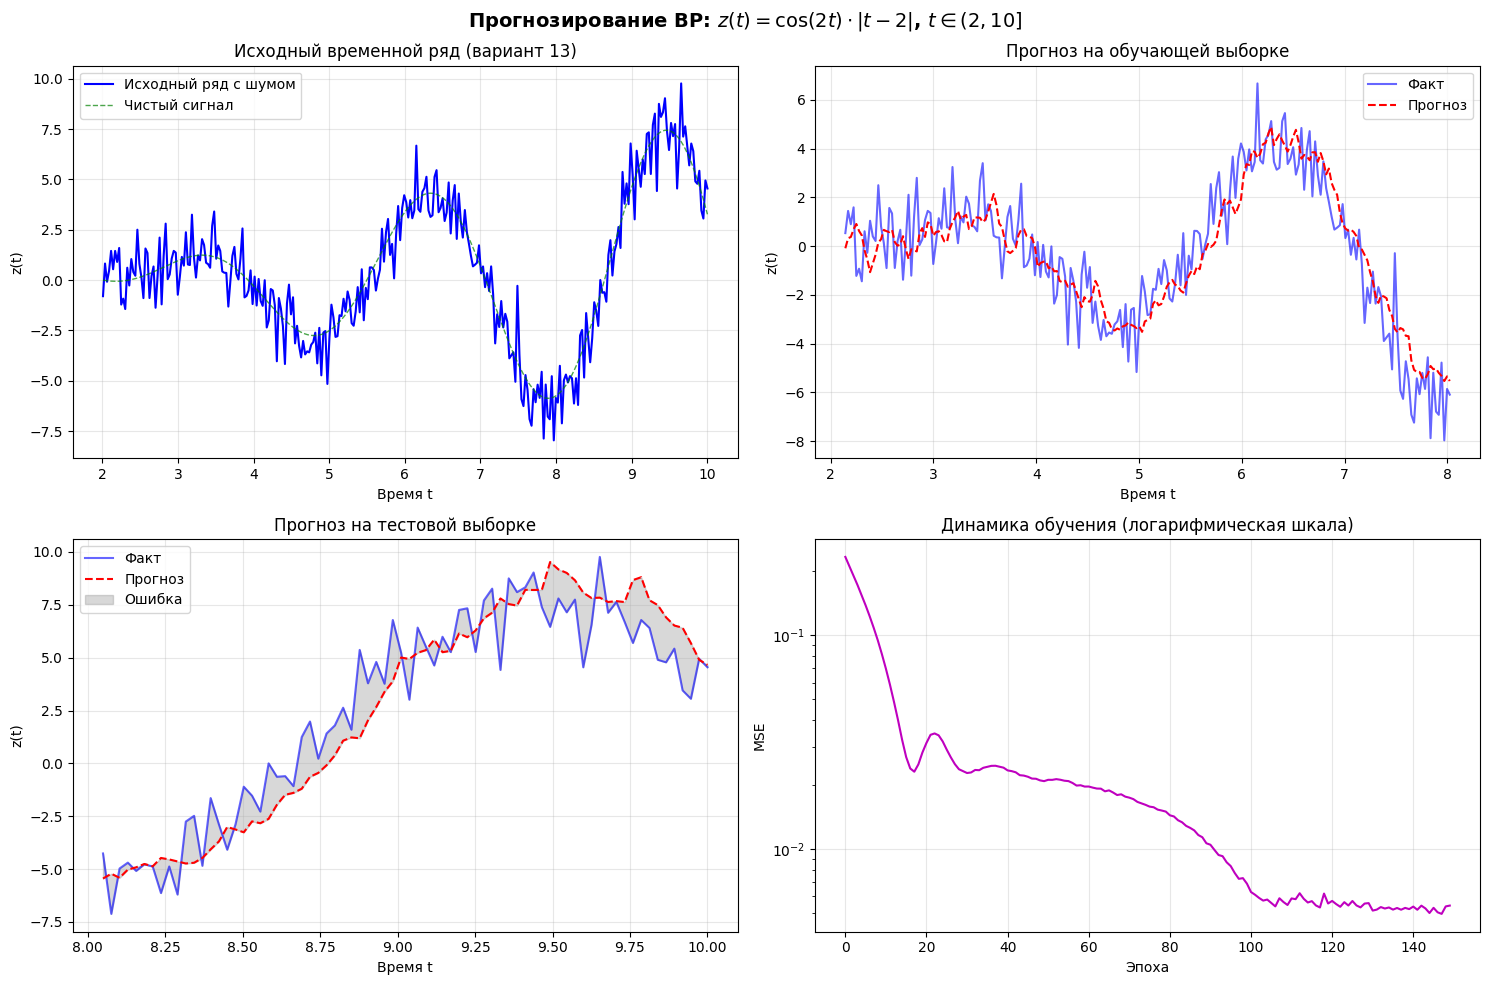

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Исходный временной ряд
axes[0, 0].plot(t, z, 'b-', linewidth=1.5, label='Исходный ряд с шумом')
axes[0, 0].plot(t, z_clean, 'g--', linewidth=1, alpha=0.7, label='Чистый сигнал')
axes[0, 0].set_title('Исходный временной ряд (вариант 13)')
axes[0, 0].set_xlabel('Время t')
axes[0, 0].set_ylabel('z(t)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Прогноз на обучающей выборке
train_time = t[lookback:lookback+len(y_train_inv)]
axes[0, 1].plot(train_time, y_train_inv, 'b-', alpha=0.6, label='Факт')
axes[0, 1].plot(train_time, y_pred_train_inv, 'r--', linewidth=1.5, label='Прогноз')
axes[0, 1].set_title('Прогноз на обучающей выборке')
axes[0, 1].set_xlabel('Время t')
axes[0, 1].set_ylabel('z(t)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Прогноз на тестовой выборке
test_time = t[lookback+train_size:lookback+train_size+len(y_test_inv)]
axes[1, 0].plot(test_time, y_test_inv, 'b-', alpha=0.6, label='Факт')
axes[1, 0].plot(test_time, y_pred_test_inv, 'r--', linewidth=1.5, label='Прогноз')
axes[1, 0].fill_between(test_time, 
                       y_test_inv.flatten(), 
                       y_pred_test_inv.flatten(), 
                       alpha=0.3, color='gray', label='Ошибка')
axes[1, 0].set_title('Прогноз на тестовой выборке')
axes[1, 0].set_xlabel('Время t')
axes[1, 0].set_ylabel('z(t)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4. Ошибка прогнозирования
axes[1, 1].plot(loss_history, 'm-', linewidth=1.5)
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Динамика обучения (логарифмическая шкала)')
axes[1, 1].set_xlabel('Эпоха')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(r'Прогнозирование ВР: $z(t) = \cos(2t) \cdot |t - 2|$, $t \in (2, 10]$', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()